In [6]:
!pip install cvlib

  Created wheel for cvlib: filename=cvlib-0.2.6-py3-none-any.whl size=10044621 sha256=db078b770ff4acd47d98f92f0236af15808ed37e8329cbf186fa74e4e676c10f
  Stored in directory: c:\users\smt051\appdata\local\pip\cache\wheels\93\ed\05\c69faa71b40d4a664aaa36e66a0947e6d8d1aaeb7232ea60d7
  Created wheel for imutils: filename=imutils-0.5.4-py3-none-any.whl size=25860 sha256=19f83901aa2fde0ee0c9d15b8b85a746de740d396dc9abe8bcfcb14feeef2302
  Stored in directory: c:\users\smt051\appdata\local\pip\cache\wheels\f5\0c\3a\61b992f7aa85de40f339e6d4970d91dddb103dd0ad6c5d58f2
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12075 sha256=c13038c2b0460df3b5c99d5dfeaee0b5b333d8e9877f6dc8e7dfd631cff5c954
  Stored in directory: c:\users\smt051\appdata\local\pip\cache\wheels\bc\13\93\a9bf6b3d3966e4af014b0dbef027fdea47393faf47e990349f
Successfully built cvlib imutils progressbar


In [2]:
import cv2
import cvlib as cv

#####  웹캠으로 스크린샷 찍기

In [ ]:

 
# open webcam (웹캠 열기)
webcam = cv2.VideoCapture(0)
 
if not webcam.isOpened():
    print("Could not open webcam")
    exit()
    
 
sample_num = 0    
captured_num = 0
    
# loop through frames
while webcam.isOpened():
    
    # read frame from webcam 
    status, frame = webcam.read()
    sample_num = sample_num + 1
    
    if not status:
        break
 
    # 이미지 내 얼굴 검출
    face, confidence = cv.detect_face(frame)
    
    print(face)
    print(confidence)
 
    # loop through detected faces
    for idx, f in enumerate(face):
        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]
 
 
        if sample_num % 8  == 0:
            captured_num = captured_num + 1
            face_in_img = frame[startY:endY, startX:endX, :]
            cv2.imwrite('./mask/face'+str(captured_num)+'.jpg', face_in_img) # 마스크 미착용 데이터 수집시 주석처리
            # cv2.imwrite('./nomask/face'+str(captured_num)+'.jpg', face_in_img) # 마스크 미착용 데이터 수집시 주석해제
 
 
    # display output
    cv2.imshow("captured frames", frame)        
    
    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# release resources
webcam.release()
cv2.destroyAllWindows()   


##### ResNet50  전이학습

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
 
    
path_dir1 = './nomask/'
path_dir2 = './mask/'
 
file_list1 = os.listdir(path_dir1) # path에 존재하는 파일 목록 가져오기
file_list2 = os.listdir(path_dir2)
 
file_list1_num = len(file_list1)
file_list2_num = len(file_list2)
 
file_num = file_list1_num + file_list2_num
 

# 이미지 전처리
num = 0;
all_img = np.float32(np.zeros((file_num, 480, 640, 3)))
all_label = np.float64(np.zeros((file_num, 1)))

for img_name in file_list1:
    img_path = path_dir1+img_name
    img = load_img(img_path, target_size=(480, 640))
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    all_img[num, :, :, :] = x
    
    all_label[num] = 0 # nomask
    num = num + 1

for img_name in file_list2:
    img_path = path_dir2+img_name
    img = load_img(img_path, target_size=(480, 640))
    
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    all_img[num, :, :, :] = x
    
    all_label[num] = 1 # mask
    num = num + 1


# 데이터셋 섞기(적절하게 훈련되게 하기 위함) 
n_elem = all_label.shape[0]
indices = np.random.choice(n_elem, size=n_elem, replace=False)
 
all_label = all_label[indices]
all_img = all_img[indices]
 

# 훈련셋 테스트셋 분할
num_train = int(np.round(all_label.shape[0]*0.8))
num_test = int(np.round(all_label.shape[0]*0.2))
 
train_img = all_img[0:num_train, :, :, :]
test_img = all_img[num_train:, :, :, :] 
 
train_label = all_label[0:num_train]
test_label = all_label[num_train:]



#%% 
# create the base pre-trained model
IMG_SHAPE = (480, 640, 3)
 
base_model = ResNet50(input_shape=IMG_SHAPE, weights='imagenet', include_top=False)
base_model.trainable = False
base_model.summary()
print("Number of layers in the base model: ", len(base_model.layers))
 
flatten_layer = Flatten()
dense_layer1 = Dense(128, activation='relu')
bn_layer1 = BatchNormalization()
dense_layer2 = Dense(1, activation=tf.nn.sigmoid)
 
model = Sequential([
        base_model,
        flatten_layer,
        dense_layer1,
        bn_layer1,
        dense_layer2,
        ])
 
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()
 
model.fit(train_img, train_label, epochs=30, batch_size=16, validation_data = (test_img, test_label))

# save model
model.save("model.h5")
 
print("Saved model to disk")  


C:\Users\SMT051\anaconda3\envs\deep\lib\site-packages\PIL\Image.py:963: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


Text(0.5, 1.0, 'binary image')

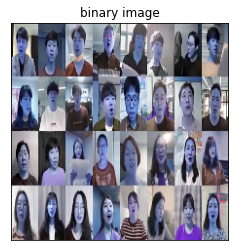

In [16]:
import matplotlib.pyplot as plt
plt.imshow(cv2.resize(frame, (224,224)), cmap="gray")
plt.xticks([])
plt.yticks([])
plt.title("binary image")



In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

In [2]:
# 모델 불러오기
model = load_model('model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 36,433,537
Trainable params: 12,845,569
Non-trainable params: 23,587,968
_________________________________________________________________


In [7]:
import cvlib as cv
import pafy
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import ImageFont, ImageDraw, Image

url = "https://www.youtube.com/watch?v=cvVFLnxGbGc" # 유튜브 영상 url
vPafy = pafy.new(url)
play = vPafy.getbest(preftype="mp4")

# 카메라 연결
try:
    print("카메라 연결 성공")
    cap = cv2.VideoCapture(play.url)
except:
    print("카메라 연결 실패")
while True:
    ret, frame = cap.read()
    frame = cv2.resize(frame, (224,224))
    # 동영상에서 한 장의 이미지를 읽는 것을 실패했다면,
    if not ret:
        cap.release()
        cv2.destroyAllWindows()
        break

    face, confidence = cv.detect_face(frame)
    
    # loop through detected faces
    for idx, f in enumerate(face):
        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]
        
        if 0 <= startX <= frame.shape[1] and 0 <= endX <= frame.shape[1] and 0 <= startY <= frame.shape[0] and 0 <= endY <= frame.shape[0]:
            
            face_region = frame[startY:endY, startX:endX]
            
            face_region1 = cv2.resize(face_region, (224, 224), interpolation = cv2.INTER_AREA)
            
            x = img_to_array(face_region1)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            prediction = model.predict(x)
            
            if prediction < 0.5: # 마스크 착용으로 판별되면, 
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,0,255), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = "No Mask ({:.2f}%)".format((1 - prediction[0][0])*100)
                cv2.putText(frame, text, (startX,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
                
            else: # 마스크 착용으로 판별되면
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = "Mask ({:.2f}%)".format(prediction[0][0]*100)
                cv2.putText(frame, text, (startX,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
                
    # display output
    cv2.imshow("mask nomask classify", frame)
    k= cv2.waitKey(33)
    if k == 49: #숫자 1을 누른 경우
        cap.release()
        cv2.destroyAllWindows()
        break

카메라 연결 성공


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node sequential/resnet50/conv1_conv/Conv2D (defined at <ipython-input-4-8f33cb75bad8>:53) ]] [Op:__inference_distributed_function_13317]

Function call stack:
distributed_function


In [8]:
import cvlib as cv
import pafy
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import ImageFont, ImageDraw, Image
model = load_model('model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 36,433,537
Trainable params: 12,845,569
Non-trainable params: 23,587,968
_________________________________________________________________


In [9]:
frame.shape

(224, 224, 3)

In [10]:
import numpy as np
import cv2

xml = 'haarcascades/haarcascade_frontalface_default.xml'
face_cascade = cv2.CascadeClassifier(xml)

cap = cv2.VideoCapture(0) # 노트북 웹캠을 카메라로 사용
cap.set(3,640) # 너비
cap.set(4,480) # 높이

while(True):
    ret, frame = cap.read()
    frame = cv2.flip(frame, 1) # 좌우 대칭
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray,1.05, 5)
    print("Number of faces detected: " + str(len(faces)))

    if len(faces):
        for (x,y,w,h) in faces:
            cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        
    cv2.imshow('result', frame)
    
    k = cv2.waitKey(30) & 0xff
    if k == 27: # Esc 키를 누르면 종료
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.5.1) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6uw63ony\opencv\modules\objdetect\src\cascadedetect.cpp:1689: error: (-215:Assertion failed) !empty() in function 'cv::CascadeClassifier::detectMultiScale'


In [12]:
# import necessary packages
import cvlib as cv
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import ImageFont, ImageDraw, Image

 
# open webcam
webcam = cv2.VideoCapture(0)
webcam.set(3,640) # 너비
webcam.set(4,480) # 높이

if not webcam.isOpened():
    print("Could not open webcam")
    exit()
    

In [4]:
import cvlib as cv
import pafy
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import ImageFont, ImageDraw, Image
model = load_model('model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 100352)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               12845184  
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 36,433,537
Trainable params: 12,845,569
Non-trainable params: 23,587,968
_________________________________________________________________


In [5]:
idx

0

In [3]:
# import necessary packages
import cvlib as cv
import cv2
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from PIL import ImageFont, ImageDraw, Image

 
# open webcam
webcam = cv2.VideoCapture(0)
webcam.set(3,640) # 너비
webcam.set(4,480) # 높이

if not webcam.isOpened():
    print("Could not open webcam")
    exit()
    

# loop through frames
while webcam.isOpened():

    # read frame from webcam 
    status, frame = webcam.read()
    
    
    if not status:
        print("Could not read frame")
        exit()

    # apply face detection
    face, confidence = cv.detect_face(frame)
    
    # loop through detected faces
    for idx, f in enumerate(face):
        
        (startX, startY) = f[0], f[1]
        (endX, endY) = f[2], f[3]
        
        if 0 <= startX <= frame.shape[1] and 0 <= endX <= frame.shape[1] and 0 <= startY <= frame.shape[0] and 0 <= endY <= frame.shape[0]:
            
            face_region = frame[startY:endY, startX:endX]
            
            face_region1 = cv2.resize(face_region, (224, 224), interpolation = cv2.INTER_AREA)
            
            
            cv2.rectangle(frame, (startX,startY), (endX,endY), (0,0,255), 2)
            x = img_to_array(face_region1)
            x = np.expand_dims(x, axis=0)
            x = preprocess_input(x)
            
            prediction = model.predict(x)

            if prediction < 0.5: # 마스크 착용으로 판별되면, 
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,0,255), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = "No Mask ({:.2f}%)".format((1 - prediction[0][0])*100)
                cv2.putText(frame, text, (startX,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255), 2)
                
            else: # 마스크 착용으로 판별되면
                cv2.rectangle(frame, (startX,startY), (endX,endY), (0,255,0), 2)
                Y = startY - 10 if startY - 10 > 10 else startY + 10
                text = "Mask ({:.2f}%)".format(prediction[0][0]*100)
                cv2.putText(frame, text, (startX,Y), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0), 2)
                
    # display output
    cv2.imshow("mask nomask classify", frame)

    # press "Q" to stop
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
    
# release resources
webcam.release()
cv2.destroyAllWindows() 
